In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1Ux85UMh6Cs2Qy30Q7VgpV4gNAW_7vfkk" -O kaggle.json > /dev/null 2>&1

In [ ]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d teejmahal20/airline-passenger-satisfaction

  0% 0.00/2.71M [00:00<?, ?B/s]
100% 2.71M/2.71M [00:00<00:00, 195MB/s]


In [ ]:
!unzip "airline-passenger-satisfaction.zip"
!rm -rf "airline-passenger-satisfaction.zip"

Archive:  airline-passenger-satisfaction.zip
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [ ]:
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

In [ ]:
df_train.isnull().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [ ]:
df_train['Arrival Delay in Minutes'].fillna(df_train['Arrival Delay in Minutes'].median(), inplace=True)

In [ ]:
df_test.isnull().sum()

Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0


In [ ]:
df_test['Arrival Delay in Minutes'].fillna(df_test['Arrival Delay in Minutes'].median(), inplace=True)

In [ ]:
cat_features = df_train.select_dtypes('object').columns.to_list()
cat_features

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

In [ ]:
unique_values_dict = {}
for col in cat_features:
  unique_values_dict[col] = df_train[col].unique()
unique_values_dict

{'Gender': array(['Male', 'Female'], dtype=object),
 'Customer Type': array(['Loyal Customer', 'disloyal Customer'], dtype=object),
 'Type of Travel': array(['Personal Travel', 'Business travel'], dtype=object),
 'Class': array(['Eco Plus', 'Business', 'Eco'], dtype=object),
 'satisfaction': array(['neutral or dissatisfied', 'satisfied'], dtype=object)}

In [ ]:
df_train.replace({'Gender':{'Male':0,'Female':1}, 'Customer Type':{'Loyal Customer':1, 'disloyal Customer':0}, 'Type of Travel':{'Business travel': 0,'Personal Travel':1}, 'Class':{'Business': 2, 'Eco':0, 'Eco Plus': 1},'satisfaction':{'neutral or dissatisfied':0, "satisfied":1}}, inplace= True)
df_test.replace({'Gender':{'Male':0,'Female':1}, 'Customer Type':{'Loyal Customer':1, 'disloyal Customer':0}, 'Type of Travel':{'Business travel': 0,'Personal Travel':1}, 'Class':{'Business': 2, 'Eco':0, 'Eco Plus': 1},'satisfaction':{'neutral or dissatisfied':0, "satisfied":1}}, inplace= True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  int64  
 3   Customer Type                      103904 non-null  int64  
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  int64  
 6   Class                              103904 non-null  int64  
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  int64  
 3   Customer Type                      25976 non-null  int64  
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  int64  
 6   Class                              25976 non-null  int64  
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

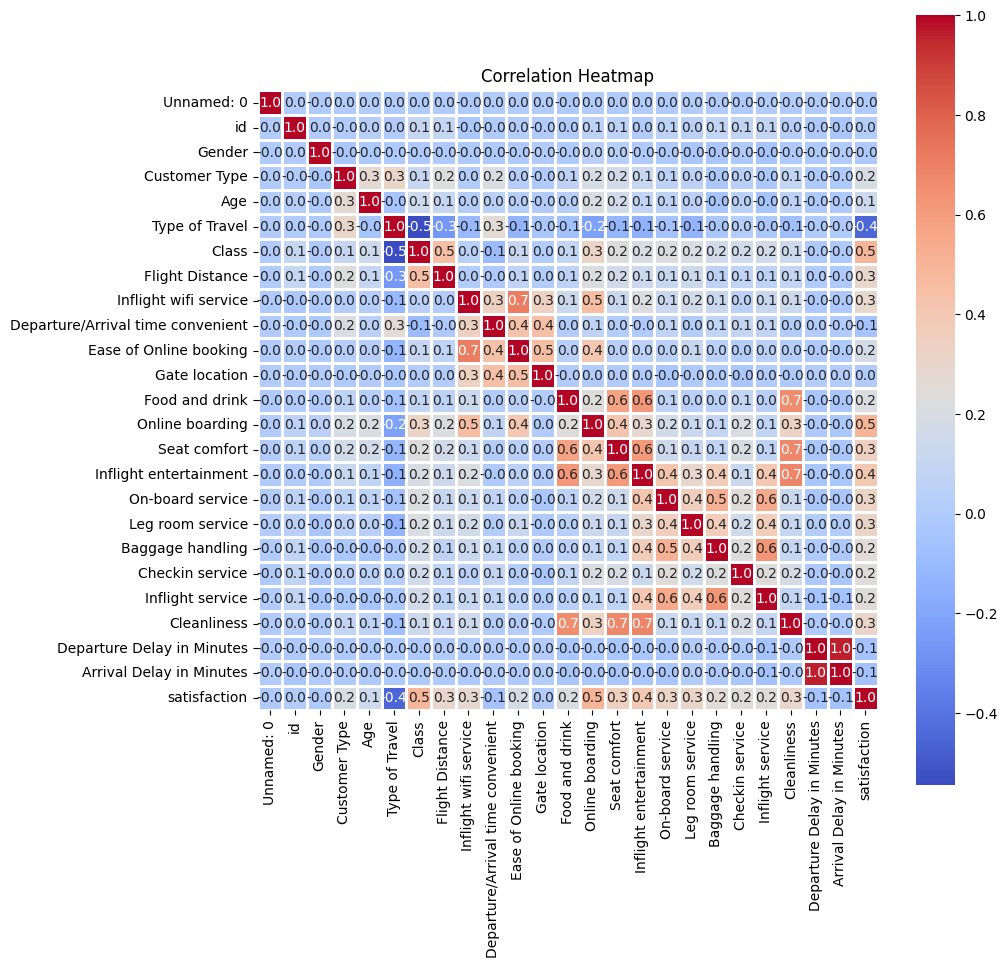

In [ ]:
corr_mat = df_train.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', linewidths=1, fmt='.1f', square = True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# we can drop Unnamed:0, id and Gender
df_train.drop(['Unnamed: 0', 'id','Gender'], axis=1, inplace=True)
df_test.drop(['Unnamed: 0', 'id','Gender'], axis=1, inplace=True)

In [ ]:
X_train = df_train.drop('satisfaction',axis=1)
y_train = df_train['satisfaction']

In [ ]:
X_test = df_test.drop('satisfaction',axis=1)
y_test = df_test['satisfaction']

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((103904, 21), (103904,), (25976, 21), (25976,))

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
#as tensor gives different datatypes which gives an error while training the model

In [ ]:
class NNmodel(nn.Module):
  def __init__(self,input_size,drop_prob=0.175):
    super(NNmodel,self).__init__()
    self.fc1=nn.Linear(input_size, 32)
    self.fc2=nn.Linear(32,64)
    self.fc3=nn.Linear(64,32)
    self.fc4=nn.Linear(32,1)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=drop_prob)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc4(x)
    x = self.sigmoid(x)
    return x

In [ ]:
input_size=X_train_tensor.shape[1]

In [ ]:
model=NNmodel(input_size)

In [ ]:
loss_fn = nn.BCELoss()
optimiser = optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
batch_size = 32
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

In [ ]:
epochs = 20
for epoch in range(epochs):
  for inputs, labels in train_loader:
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels.view(-1,1))
    loss.backward()
    optimiser.step()

In [ ]:
with torch.no_grad():
  model.eval()
  y_pred_probs = model(X_test_tensor)
  predictions = (y_pred_probs > 0.5).float().flatten()

In [ ]:
predictions = predictions.numpy()
y_test = y_test_tensor.numpy()

In [ ]:
class_report_dict = classification_report(y_test, predictions,output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).transpose()
class_report_df

,precision,recall,f1-score,support
0.0,0.956097,0.966857,0.961447,14573.000000
1.0,0.957025,0.943261,0.950093,11403.000000
accuracy,0.956498,0.956498,0.956498,0.956498
macro avg,0.956561,0.955059,0.955770,25976.000000
weighted avg,0.956504,0.956498,0.956462,25976.000000


In [ ]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.9564983061287342